In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import os

# plot omega

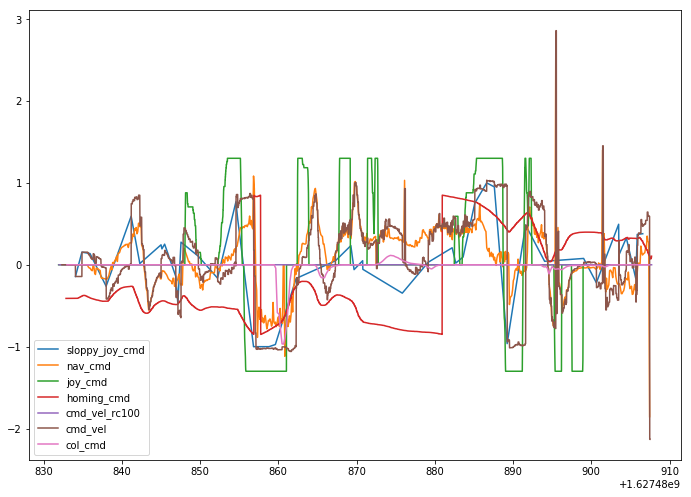

In [10]:
participent_nr = 3  # choose participent



bag_name = "main_circuit"

twist_topic_list = ['sloppy_joy_cmd', 'nav_cmd', 'joy_cmd', 'homing_cmd', 'cmd_vel_rc100', 'cmd_vel', 'col_cmd']



plt.figure(figsize=(11.69,8.27))
for topic_name in twist_topic_list:
    twist_df = pd.read_csv("../experimental_data/participent_" + str(participent_nr) + "/" + bag_name + "/twist_" + topic_name + ".csv")
    plt.plot(twist_df['time'], twist_df['omega'], label=topic_name)
plt.legend(loc="lower left")
plt.show()

# plot odom

-0.15060411587407144
-1.5166185588166148
2.6093492448313205


IOError: [Errno 2] File ../experimental_data/participent_5/main_circuit/odom.csv does not exist: '../experimental_data/participent_5/main_circuit/odom.csv'

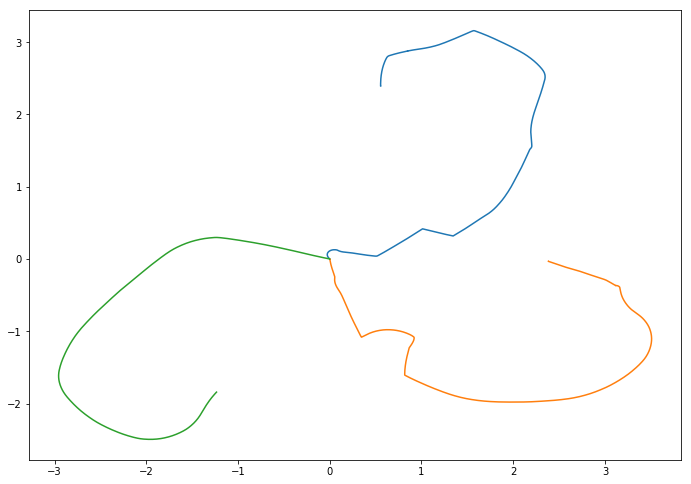

In [11]:
def rotata_odom(odom_df):
    new_df = deepcopy(odom_df)
    initial_yaw = odom_df['yaw'][0]
    rot = np.array([[np.cos(initial_yaw), -np.sin(initial_yaw)], [np.sin(initial_yaw), np.cos(initial_yaw)]])
    for index, row in new_df.iterrows():
        


participent_numbers = [2,3,4,5] 
plt.figure(figsize=(11.69,8.27))
for participent_nr in participent_numbers:
    odom_df = pd.read_csv("../experimental_data/participent_" + str(participent_nr) + "/" + bag_name + "/odom.csv")
    plt.plot(odom_df['x'], odom_df['y'], label="participent "+str(participent_nr))
    print(odom_df['yaw'][0])
plt.legend(loc="lower left")
plt.axis('equal')
plt.show()

In [ ]:
# create a HTML file for easy access (without jupyter)
os.system('jupyter nbconvert --to html visualization.ipynb') 
os.system('mv visualization.html ./html') # move to html folder